# Emotion Recognition

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.11.1


# Importing Images and Exploring

In [89]:
# Creating directories to each path in the sentiment folder for test data

train_angry_dir = os.path.join('./sentiment/test/angry')
train_disgust_dir = os.path.join('./sentiment/test/disgust')
train_fear_dir = os.path.join('./sentiment/test/fear')
train_happy_dir = os.path.join('./sentiment/test/happy')
train_neutral_dir = os.path.join('./sentiment/test/neutral')
train_sad_dir = os.path.join('./sentiment/test/sad')
train_surprise_dir = os.path.join('./sentiment/test/surprise')

In [91]:
train_angry_names = os.listdir(train_angry_dir)
train_disgust_names = os.listdir(train_disgust_dir)
train_fear_names = os.listdir(train_fear_dir)
train_happy_names = os.listdir(train_happy_dir)
train_neutral_names = os.listdir(train_neutral_dir)
train_sad_names = os.listdir(train_sad_dir)
train_happy_names = os.listdir(train_neutral_dir)
train_surprise_names = os.listdir(train_surprise_dir)

print(train_angry_names[:10])

['PrivateTest_14565821.jpg', 'PublicTest_65465298.jpg', 'PublicTest_93558553.jpg', 'PublicTest_28963544.jpg', 'PublicTest_90347378.jpg', 'PrivateTest_3309033.jpg', 'PublicTest_19319090.jpg', 'PublicTest_1373732.jpg', 'PrivateTest_89959696.jpg', 'PrivateTest_87526826.jpg']


In [92]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

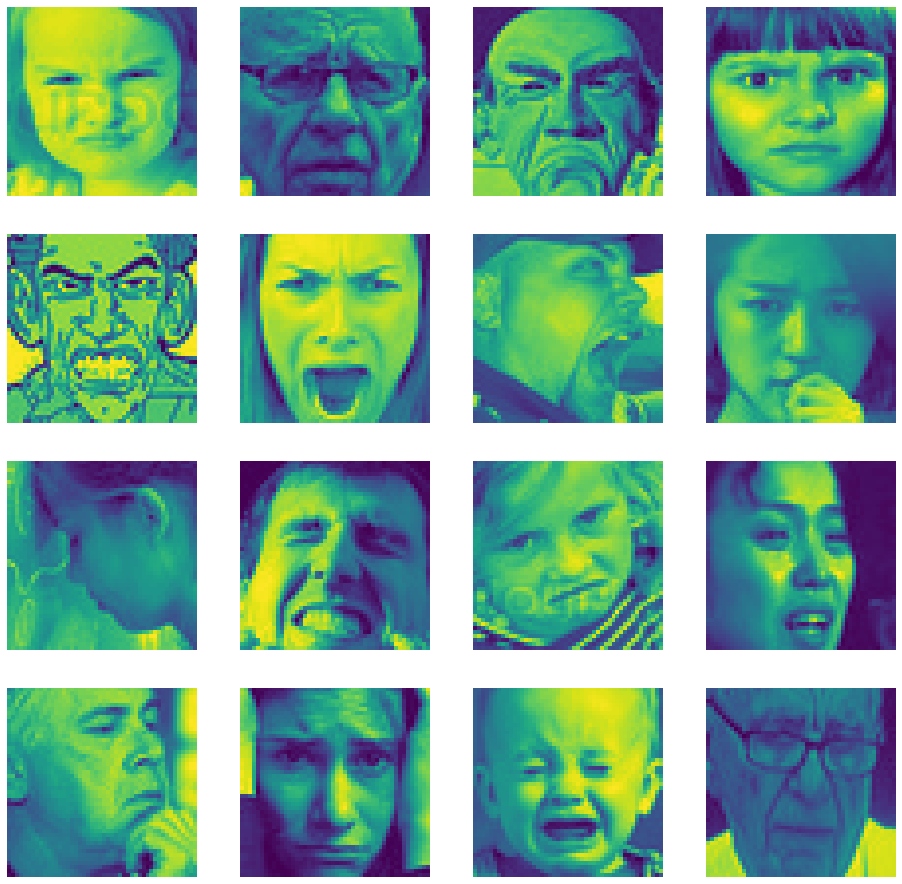

In [97]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_angry_pix = [os.path.join(train_angry_dir, fname) 
                for fname in train_angry_names[pic_index-8:pic_index]]
next_sad_pix = [os.path.join(train_sad_dir, fname) 
                for fname in train_sad_names[pic_index-8:pic_index]]


for i, img_path in enumerate(next_angry_pix+next_sad_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Callback function

In [682]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > .73:
            print("\nReached 73.0% accuracy so cancelling training!")
            self.model.stop_training = True    

# Preprocess Data

In [688]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=15,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   validation_split=0.3)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        './sentiment/train',  # This is the source directory for training images
        target_size = (48, 48),  
        batch_size = 64,
        color_mode = "grayscale",
        class_mode = 'categorical',
        subset='training',
        shuffle = True)

val_generator = train_datagen.flow_from_directory(
        './sentiment/train',  # This is the source directory for training images
        target_size=(48, 48),  
        batch_size=64,
        color_mode = "grayscale",
        class_mode='categorical',
        subset='validation',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        './sentiment/test',  # This is the source directory for training images
        target_size = (48, 48),  
        batch_size = 64,
        color_mode = "grayscale",
        class_mode = 'categorical')


Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Building Small Model

In [689]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 48x48 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    # The second convolution
    tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # The third convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # The fourth convolution
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

In [690]:
model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_206 (Conv2D)         (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_206 (MaxPooli  (None, 24, 24, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_89 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_207 (Conv2D)         (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_13 (Bat  (None, 24, 24, 128)    

In [691]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0004),
              metrics=['accuracy'])

In [692]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

callback = myCallback()

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)


history = model.fit(
      train_generator, 
      epochs=70,
      verbose=1,
      validation_data = val_generator,
      callbacks=[callback, lr_scheduler, early_stopping])

Epoch 1/70
315/315 [==============================] - 155s 489ms/step - loss: 2.2411 - accuracy: 0.2017 - val_loss: 3.3261 - val_accuracy: 0.1728 - lr: 4.0000e-04
Epoch 2/70
315/315 [==============================] - 6105s 19s/step - loss: 1.9760 - accuracy: 0.2291 - val_loss: 1.9213 - val_accuracy: 0.2587 - lr: 4.0000e-04
Epoch 3/70
315/315 [==============================] - 19341s 62s/step - loss: 1.8929 - accuracy: 0.2487 - val_loss: 1.8300 - val_accuracy: 0.2677 - lr: 4.0000e-04
Epoch 4/70
315/315 [==============================] - 2760s 9s/step - loss: 1.8394 - accuracy: 0.2711 - val_loss: 1.7566 - val_accuracy: 0.3092 - lr: 4.0000e-04
Epoch 5/70
315/315 [==============================] - 154s 490ms/step - loss: 1.7460 - accuracy: 0.3156 - val_loss: 2.0100 - val_accuracy: 0.2983 - lr: 4.0000e-04
Epoch 6/70
315/315 [==============================] - 153s 487ms/step - loss: 1.6650 - accuracy: 0.3517 - val_loss: 1.8017 - val_accuracy: 0.3258 - lr: 4.0000e-04
Epoch 7/70
315/315 [=====

315/315 [==============================] - ETA: 0s - loss: 1.0280 - accuracy: 0.6098
Epoch 50: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
315/315 [==============================] - 150s 478ms/step - loss: 1.0280 - accuracy: 0.6098 - val_loss: 1.1234 - val_accuracy: 0.5740 - lr: 2.0000e-04
Epoch 51/70
315/315 [==============================] - 155s 493ms/step - loss: 1.0045 - accuracy: 0.6227 - val_loss: 1.0456 - val_accuracy: 0.6074 - lr: 1.0000e-04
Epoch 52/70
315/315 [==============================] - 152s 484ms/step - loss: 0.9972 - accuracy: 0.6240 - val_loss: 1.0269 - val_accuracy: 0.6093 - lr: 1.0000e-04
Epoch 53/70
315/315 [==============================] - 151s 480ms/step - loss: 1.0043 - accuracy: 0.6227 - val_loss: 1.0363 - val_accuracy: 0.6098 - lr: 1.0000e-04
Epoch 54/70
315/315 [==============================] - 153s 485ms/step - loss: 0.9912 - accuracy: 0.6262 - val_loss: 1.0266 - val_accuracy: 0.6137 - lr: 1.0000e-04
Epoch 55/70
315/315 [=========

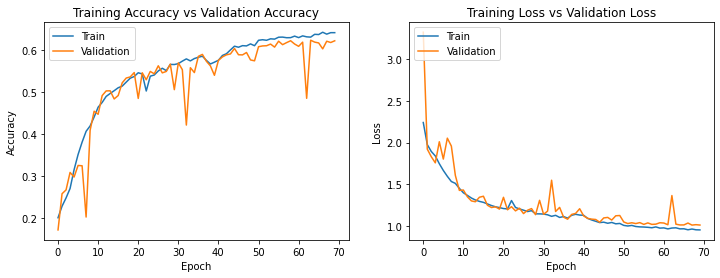

In [693]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

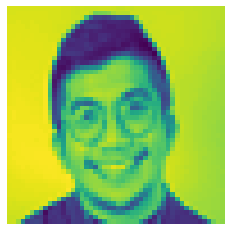

In [748]:
from PIL import Image

# Load and preprocess the new image
new_image = Image.open('./rein-dj/test/dj-test/dj3.png')
new_image = new_image.resize((48, 48))
new_image = new_image.convert('L')
new_image = np.array(new_image) / 255.0
new_image = np.expand_dims(new_image, axis=0)

# Display the image
plt.imshow(new_image[0])
plt.axis('off')
plt.show()

In [749]:
# Use the trained model to predict the output
predictions = model.predict(new_image)

predictions[0]

1/1 [==============================] - 0s 23ms/step


array([7.1881111e-03, 4.2750980e-05, 8.2883239e-03, 8.6517715e-01,
       9.6446544e-02, 3.8725657e-03, 1.8984463e-02], dtype=float32)

In [750]:
train_generator.class_indices
label_dict = ['angry', 'disgust', 'fear','happy', 'neutral', 'sad', 'surprise']

In [751]:
res = np.argmax(predictions[0])

In [752]:
print('predicted Label for that image is: {}'.format(label_dict[res]))

predicted Label for that image is: happy
